# File Storage Indexing - Hariom Vyas (HD59451)

**Note:** Please use Google Colab for this Notebook

**Dataset:** When you will run this notebook, it will take your Google Drive as your Dataset. Mine was 2.8GB. Yours may depend on the data uploaded on your Google Drive.

The aim of the project is to go through your Google Drive Storage and create an index of that. Program crawls through your google drive and creates a list of all the filepaths and its metadata.

After getting filepaths, it starts extracting infomration from within the files.

List of file types from which program can extract information is:
* Text
* Docx
* PDF
* Python



## Project Flow
* Connecting to Google Drive
* Setting up PySpark in Colab
* Getting Filepaths of Google Drive Files
* Starting our Spark Journey
* Data Insights and Pre-processing
* Functions to Extract data from different forms of files
* Data Extraction using User Defined Functions
* Query Time
* Continuous Index Updater
* Saving Indexes to CSV

In [ ]:
# Connecting my Google Drive to this notebook

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Setting up PySpark in Colab

In [ ]:
## Spark is written in Scala programming language and requires the Java Virtual Machine (JVM) to run. Therefore, our first task is to download Java.

!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
## Now we will install Apache Spark 3.3.1 with Hadoop 3.0.0 and Scala 2.13

!wget -q https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3-scala2.13.tgz

In [ ]:
## Unzipping the file

!tar xf /content/drive/MyDrive/spark-3.3.1-bin-hadoop3-scala2.13.tgz

In [ ]:
## We need findspark to locate Spark on the system and import it as a regular library.

!pip install -q findspark

In [ ]:
## Setting environment path which will unable us to run Pyspark in the Colab environment.

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.1-bin-hadoop3-scala2.13"

In [ ]:
## Testing if Spark is installed properly

import findspark
findspark.init()

In [ ]:
## Importing SparkSession from pyspark.sql and creating a SparkSession

from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("NimbusStorage")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [ ]:
spark

## Getting Filepaths of Google Drive Files

Goal of this Project is to create an indexing of my google drive. So I can perform easy searches on files stored on my Google Drive.

In [ ]:
## Importing OS module which will let us perform operations on files and directories

import os

folder = '.'
filepaths = [os.path.join(folder, f) for f in os.listdir(folder)]

In [ ]:
## Finding filepaths and directory paths

filepaths = [f.path for f in os.scandir('.') if f.is_file()]
dirpaths  = [f.path for f in os.scandir('.') if f.is_dir()]

In [ ]:
## Printing filepaths and directorypaths

for (dirpath, dirnames, filenames) in os.walk('.'):
    for f in filenames:
        print('FILE :', os.path.join(dirpath, f))
    for d in dirnames:
        print('DIRECTORY :', os.path.join(dirpath, d))

Streaming output truncated to the last 5000 lines.
FILE : ./drive/MyDrive/UMBC/Data602/Project/venv/Lib/site-packages/pandas/_libs/interval.cp39-win_amd64.pyd
FILE : ./drive/MyDrive/UMBC/Data602/Project/venv/Lib/site-packages/pandas/_libs/missing.pyi
FILE : ./drive/MyDrive/UMBC/Data602/Project/venv/Lib/site-packages/pandas/_libs/interval.pyi
FILE : ./drive/MyDrive/UMBC/Data602/Project/venv/Lib/site-packages/pandas/_libs/ops_dispatch.pyx
FILE : ./drive/MyDrive/UMBC/Data602/Project/venv/Lib/site-packages/pandas/_libs/lib.pyi
FILE : ./drive/MyDrive/UMBC/Data602/Project/venv/Lib/site-packages/pandas/_libs/index.pyi
FILE : ./drive/MyDrive/UMBC/Data602/Project/venv/Lib/site-packages/pandas/_libs/join.pyx
FILE : ./drive/MyDrive/UMBC/Data602/Project/venv/Lib/site-packages/pandas/_libs/indexing.cp39-win_amd64.pyd
FILE : ./drive/MyDrive/UMBC/Data602/Project/venv/Lib/site-packages/pandas/_libs/parsers.pyi
FILE : ./drive/MyDrive/UMBC/Data602/Project/venv/Lib/site-packages/pandas/_libs/writers.pyx


In [ ]:
## Printing Stats of a random filepath

random_filepath = "./drive/MyDrive/UMBC/Data605/Paper1/Vyas_Hariom_Paper1.docx"
stat_output = os.stat(random_filepath)
print("Stat Output: ", stat_output)
print("Stat Output Type: ", type(stat_output))

Stat Output:  os.stat_result(st_mode=33152, st_ino=6898, st_dev=42, st_nlink=1, st_uid=0, st_gid=0, st_size=26073, st_atime=1670972833, st_mtime=1646020812, st_ctime=1670972833)
Stat Output Type:  <class 'os.stat_result'>


Here we are getting lots of information including:
* **st_mode:** It represents file type and file mode bits (permissions).
* **st_ino:** It represents the inode number on Unix and the file index on Windows platform.
* **st_dev:** It represents the identifier of the device on which this file resides.
* **st_nlink:** It represents the number of hard links.
* **st_uid:** It represents the user identifier of the file owner.
* **st_gid:** It represents the group identifier of the file owner.
* **st_size:** It represents the size of the file in bytes.
* **st_atime:** It represents the time of most recent access. It is expressed in seconds.
* **st_mtime:** It represents the time of most recent content modification. It is expressed in seconds.
* **st_ctime:** It represents the time of most recent metadata change on Unix and creation time on Windows. It is expressed in seconds.

In [ ]:
## Printing Stats of all the filepaths

for (dirpath, dirnames, filenames) in os.walk('.'):
    for f in filenames:
        print('\nFILE : ', os.path.join(dirpath, f))
        print('Stats: ', os.stat(os.path.join(dirpath, f)))

Streaming output truncated to the last 5000 lines.
FILE :  ./drive/MyDrive/UMBC/Data601/Project3/Project3.zip
Stats:  os.stat_result(st_mode=33152, st_ino=4523, st_dev=42, st_nlink=1, st_uid=0, st_gid=0, st_size=26239978, st_atime=1670972623, st_mtime=1652846178, st_ctime=1670972623)

FILE :  ./drive/MyDrive/UMBC/Data601/Project3/PresentationScript.docx
Stats:  os.stat_result(st_mode=33152, st_ino=4524, st_dev=42, st_nlink=1, st_uid=0, st_gid=0, st_size=12433, st_atime=1670972812, st_mtime=1652910214, st_ctime=1670972812)

FILE :  ./drive/MyDrive/UMBC/Data601/Project3/~$Vyas_Hariom_Project3_Presentation.pptx
Stats:  os.stat_result(st_mode=33152, st_ino=4525, st_dev=42, st_nlink=1, st_uid=0, st_gid=0, st_size=165, st_atime=1670972813, st_mtime=1653360806, st_ctime=1670972813)

FILE :  ./drive/MyDrive/UMBC/Data601/Project3/Vyas_Hariom_Project3.ipynb
Stats:  os.stat_result(st_mode=33152, st_ino=4526, st_dev=42, st_nlink=1, st_uid=0, st_gid=0, st_size=2984872, st_atime=1670972650, st_mtime

In [ ]:
## To get certain things we require to create our dataset by accesing each

print(os.path.getsize(random_filepath))
print(os.path.getmtime(random_filepath))
print(os.path.getctime(random_filepath))

26073
1646020812.0
1670972833.0


In [ ]:
## For recording the time stamp
from datetime import datetime

## Creating a list containg path of the files and its important metadata that we will use in future

filepaths_list = []

for (dirpath, dirnames, filenames) in os.walk('.'):
    for f in filenames:
        print('\nFILE : ', os.path.join(dirpath, f))
        currentDateAndTime = datetime.now()
        filepaths_list.append((
            os.path.join(dirpath, f),
            # os.path.get(os.path.join(dirpath, f)),
            # os.path.getino(os.path.join(dirpath, f)),
            # os.path.getdev(os.path.join(dirpath, f)),
            # os.path.getnlink(os.path.join(dirpath, f)),
            # os.path.getuid(os.path.join(dirpath, f)),
            # os.path.getgid(os.path.join(dirpath, f)),
            os.path.getsize(os.path.join(dirpath, f)),
            os.path.getatime(os.path.join(dirpath, f)),
            os.path.getmtime(os.path.join(dirpath, f)),
            os.path.getctime(os.path.join(dirpath, f)),
            currentDateAndTime
        ))
print(filepaths_list)

Streaming output truncated to the last 5000 lines.
FILE :  ./drive/MyDrive/UMBC/Data602/Project/venv/Lib/site-packages/rich/__init__.py

FILE :  ./drive/MyDrive/UMBC/Data602/Project/venv/Lib/site-packages/rich/markdown.py

FILE :  ./drive/MyDrive/UMBC/Data602/Project/venv/Lib/site-packages/rich/ansi.py

FILE :  ./drive/MyDrive/UMBC/Data602/Project/venv/Lib/site-packages/rich/pretty.py

FILE :  ./drive/MyDrive/UMBC/Data602/Project/venv/Lib/site-packages/rich/prompt.py

FILE :  ./drive/MyDrive/UMBC/Data602/Project/venv/Lib/site-packages/rich/traceback.py

FILE :  ./drive/MyDrive/UMBC/Data602/Project/venv/Lib/site-packages/rich/padding.py

FILE :  ./drive/MyDrive/UMBC/Data602/Project/venv/Lib/site-packages/rich/_loop.py

FILE :  ./drive/MyDrive/UMBC/Data602/Project/venv/Lib/site-packages/rich/_pick.py

FILE :  ./drive/MyDrive/UMBC/Data602/Project/venv/Lib/site-packages/rich/default_styles.py

FILE :  ./drive/MyDrive/UMBC/Data602/Project/venv/Lib/site-packages/rich/segment.py

FILE :  ./dr

In [ ]:
!pip install folderstats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!folderstats /content/drive/MyDrive -p -i -v -o drive.csv

2022-12-13 23:51:30, folderstats DEBUG FOLDER: /content/drive/MyDrive/Colab Notebooks
2022-12-13 23:51:30, folderstats DEBUG FOLDER: /content/drive/MyDrive/UMBC
2022-12-13 23:51:30, folderstats DEBUG FOLDER: /content/drive/MyDrive/UMBC/Data602
2022-12-13 23:51:30, folderstats DEBUG FOLDER: /content/drive/MyDrive/UMBC/Data602/PPT Presentation
2022-12-13 23:51:30, folderstats DEBUG FOLDER: /content/drive/MyDrive/UMBC/Data602/Project
2022-12-13 23:51:30, folderstats DEBUG FOLDER: /content/drive/MyDrive/UMBC/Data602/Project/venv
2022-12-13 23:51:30, folderstats DEBUG FOLDER: /content/drive/MyDrive/UMBC/Data602/Project/venv/etc
2022-12-13 23:51:30, folderstats DEBUG FOLDER: /content/drive/MyDrive/UMBC/Data602/Project/venv/etc/jupyter
2022-12-13 23:51:30, folderstats DEBUG FOLDER: /content/drive/MyDrive/UMBC/Data602/Project/venv/etc/jupyter/nbconfig
2022-12-13 23:51:30, folderstats DEBUG FOLDER: /content/drive/MyDrive/UMBC/Data602/Project/venv/etc/jupyter/nbconfig/notebook.d
2022-12-13 23:51

In [ ]:
import folderstats

df = folderstats.folderstats('/content/', ignore_hidden=True)
df.head()

,id,path,name,extension,size,atime,mtime,ctime,folder,num_files,depth,parent,uid
0,2,/content/Indexes.csv,Indexes.csv,None,0,2022-12-13 23:50:41,2022-12-13 23:41:18,2022-12-13 23:41:18,True,0.0,1,1,0
1,3,/content/drive.csv,drive,csv,1351067,2022-12-13 23:31:47,2022-12-13 23:51:35,2022-12-13 23:51:35,False,NaN,0,1,0
2,6,/content/spark-3.3.1-bin-hadoop3-scala2.13/lic...,LICENSE-slf4j,txt,1148,2022-12-13 23:50:25,2022-10-15 08:15:25,2022-12-13 23:50:25,False,NaN,2,5,110302528
3,7,/content/spark-3.3.1-bin-hadoop3-scala2.13/lic...,LICENSE-dnsjava,txt,1314,2022-12-13 23:50:25,2022-10-15 08:15:25,2022-12-13 23:50:25,False,NaN,2,5,110302528
4,8,/content/spark-3.3.1-bin-hadoop3-scala2.13/lic...,LICENSE-scala,txt,1513,2022-12-13 23:50:25,2022-10-15 08:15:25,2022-12-13 23:50:25,False,NaN,2,5,110302528


In [ ]:
df.to_excel("before.xlsx")

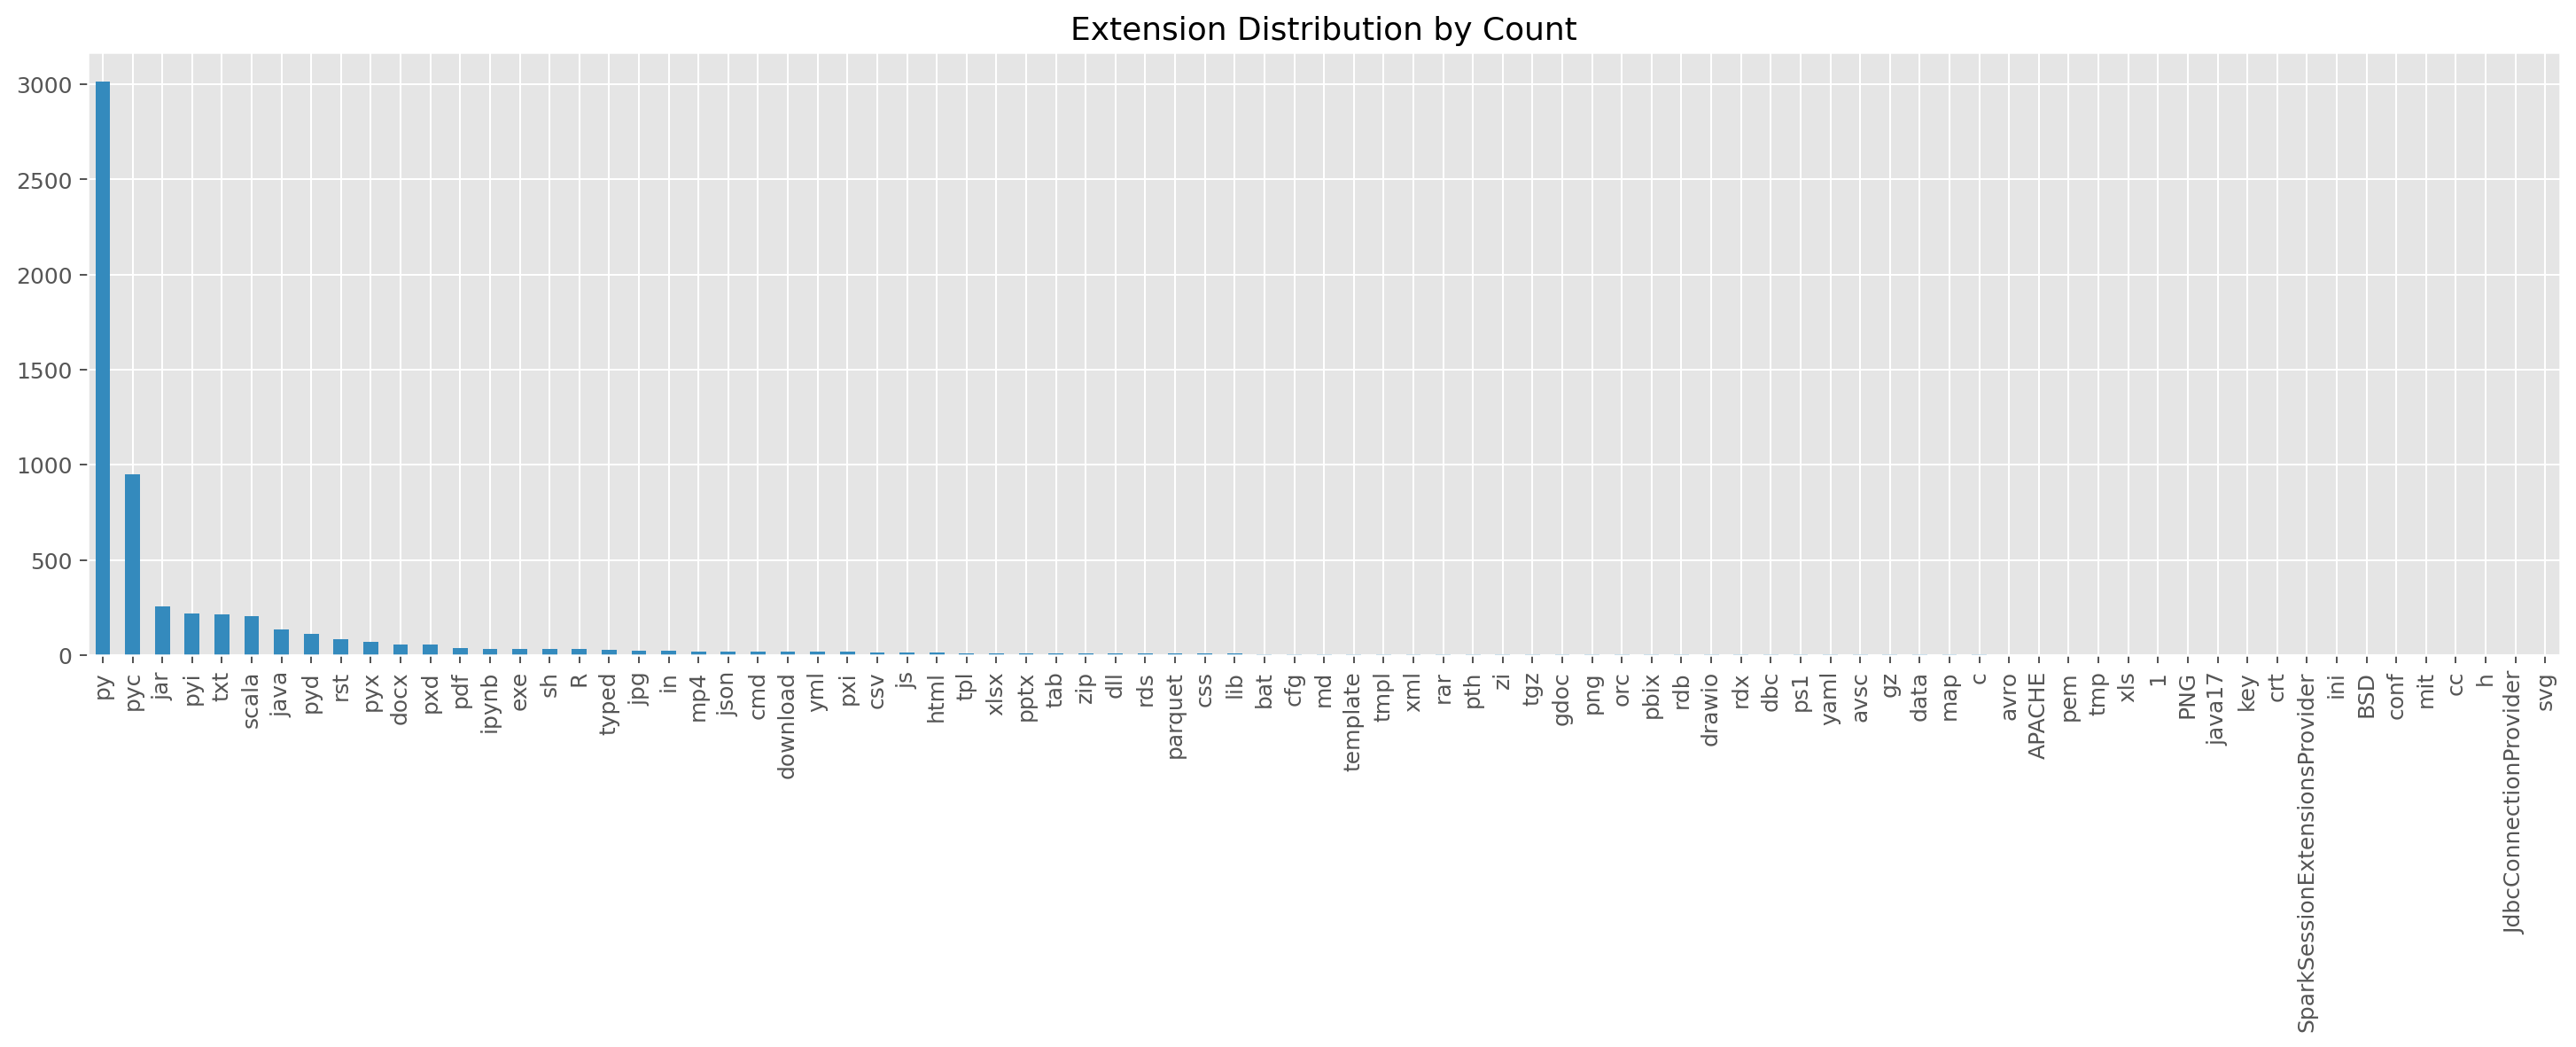

In [ ]:
## Exploring File Distribution using Matplotlib

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(20, 5), dpi=180)

with plt.style.context('ggplot'):
    df['extension'].value_counts().plot(
        kind='bar', color='C1', title='Extension Distribution by Count');

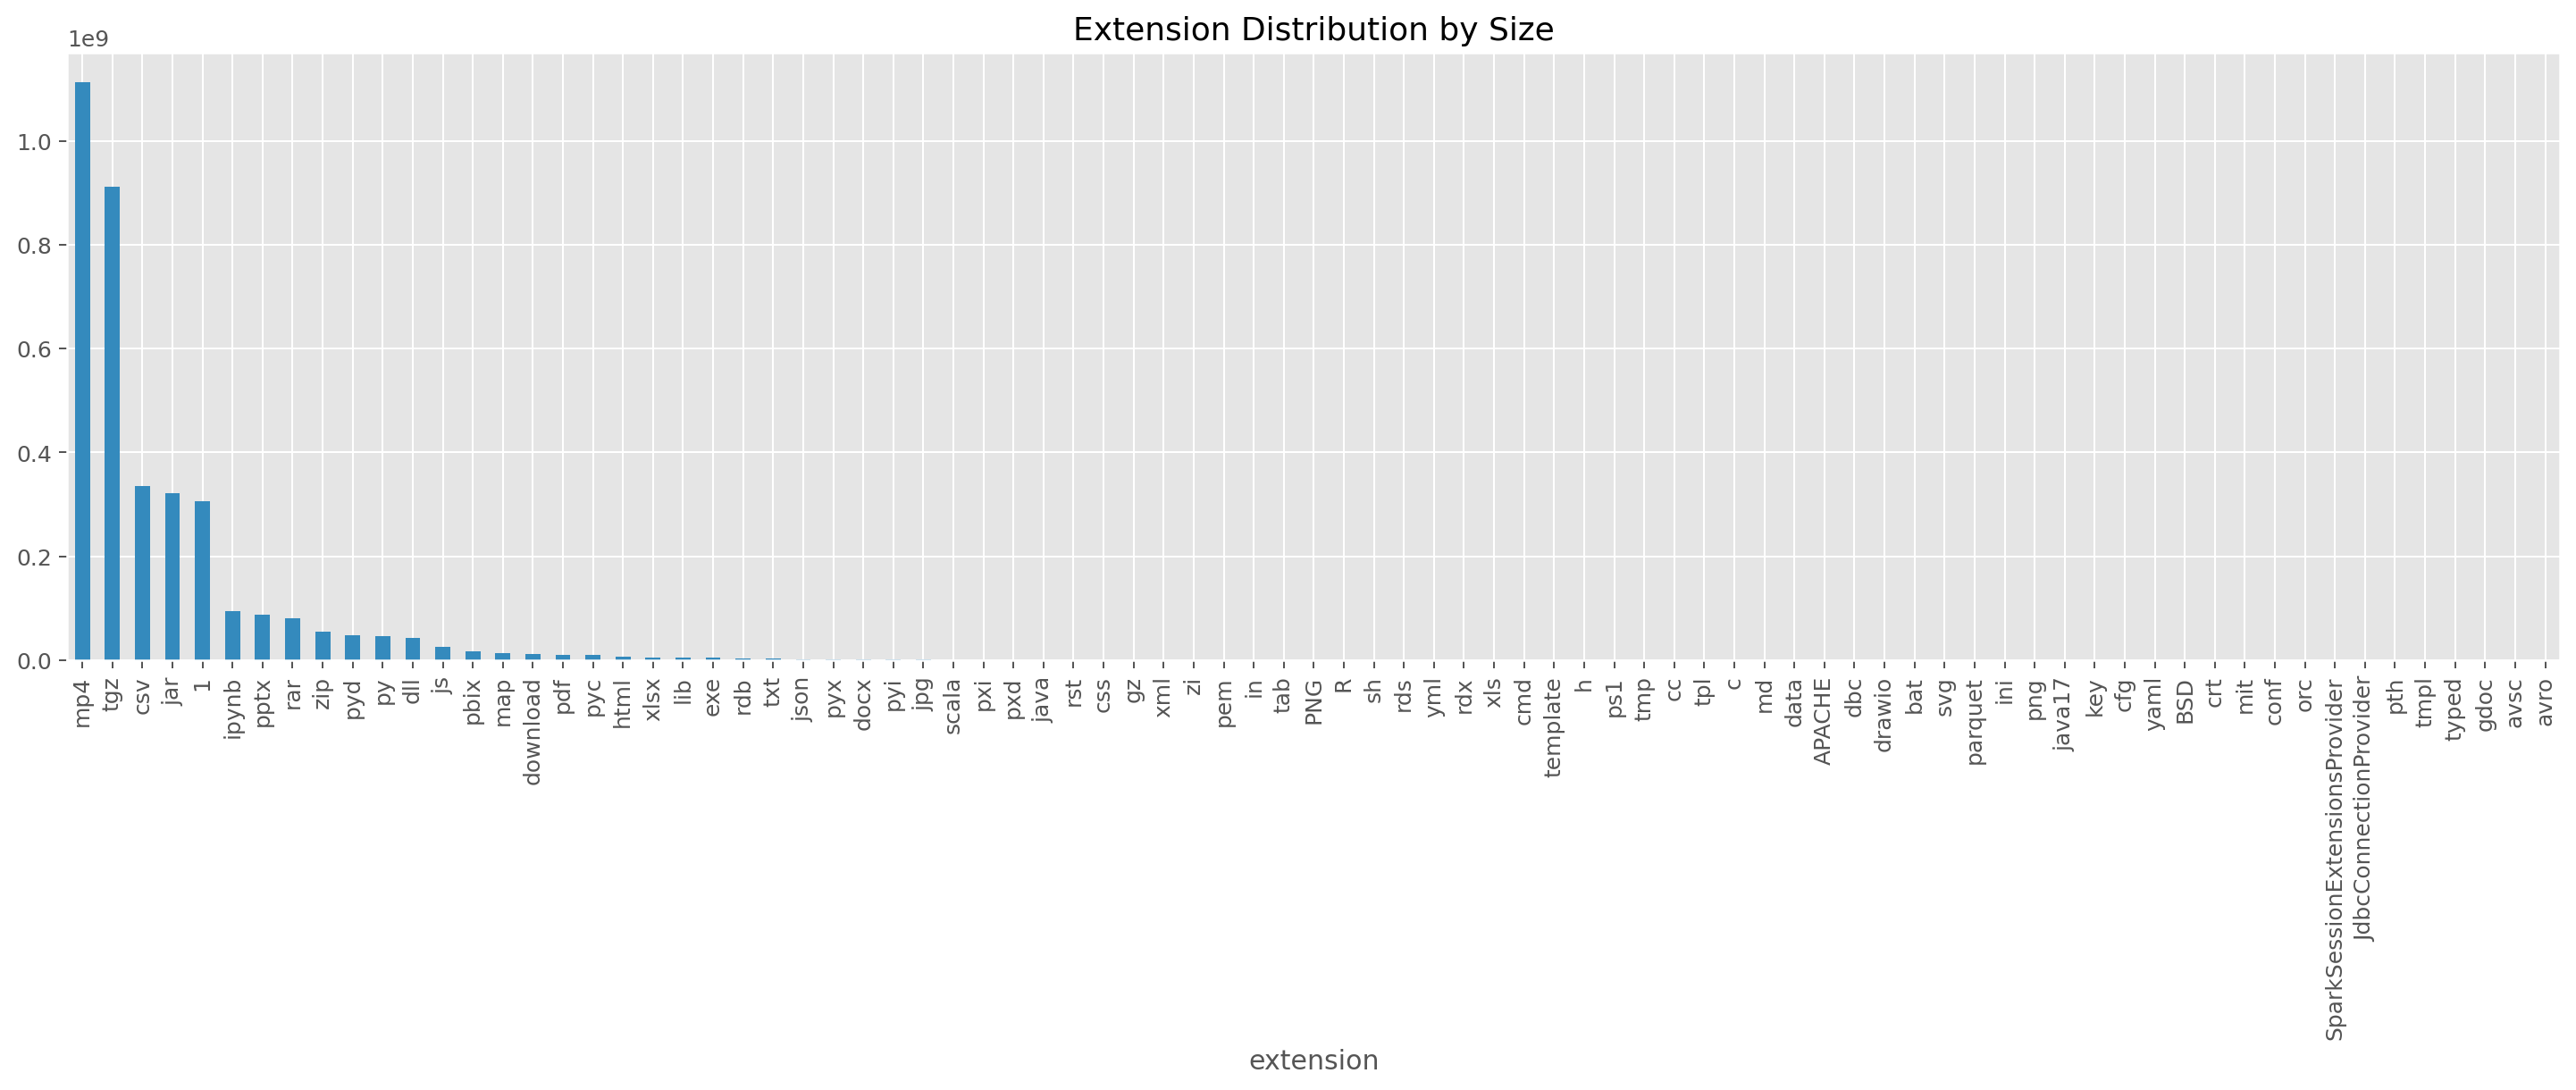

In [ ]:
## Extension Distribution by Size

figure(figsize=(20, 5), dpi=180)

with plt.style.context('ggplot'):
    # Group by extension and sum all sizes for each extension
    extension_sizes = df.groupby('extension')['size'].sum()
    # Sort elements by size
    extension_sizes = extension_sizes.sort_values(ascending=False)

    extension_sizes.plot(
        kind='bar', color='C1', title='Extension Distribution by Size');

In [ ]:
!pip install squarify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


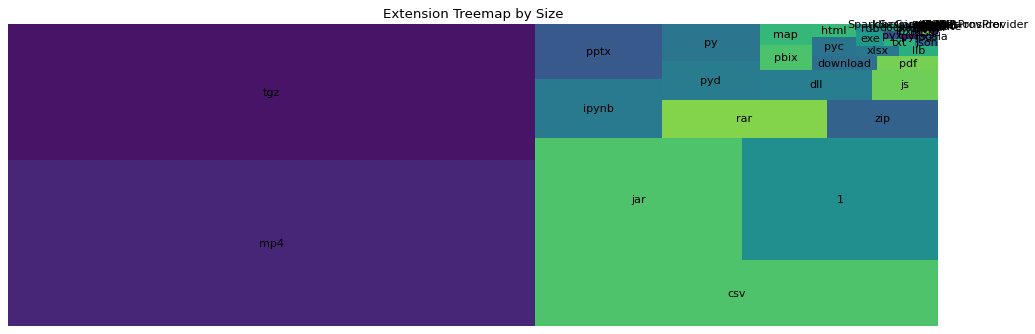

In [ ]:
## Treemap with Squarify module to show file counts based on Size

import squarify

# Group by extension and sum all sizes for each extension
extension_sizes = df.groupby('extension')['size'].sum()
# Sort elements by size
extension_counts = extension_sizes.sort_values(ascending=False)
figure(figsize=(15, 5), dpi=80)
squarify.plot(sizes=extension_counts.values, label=extension_counts.index.values)
plt.title('Extension Treemap by Size')
plt.axis('off');

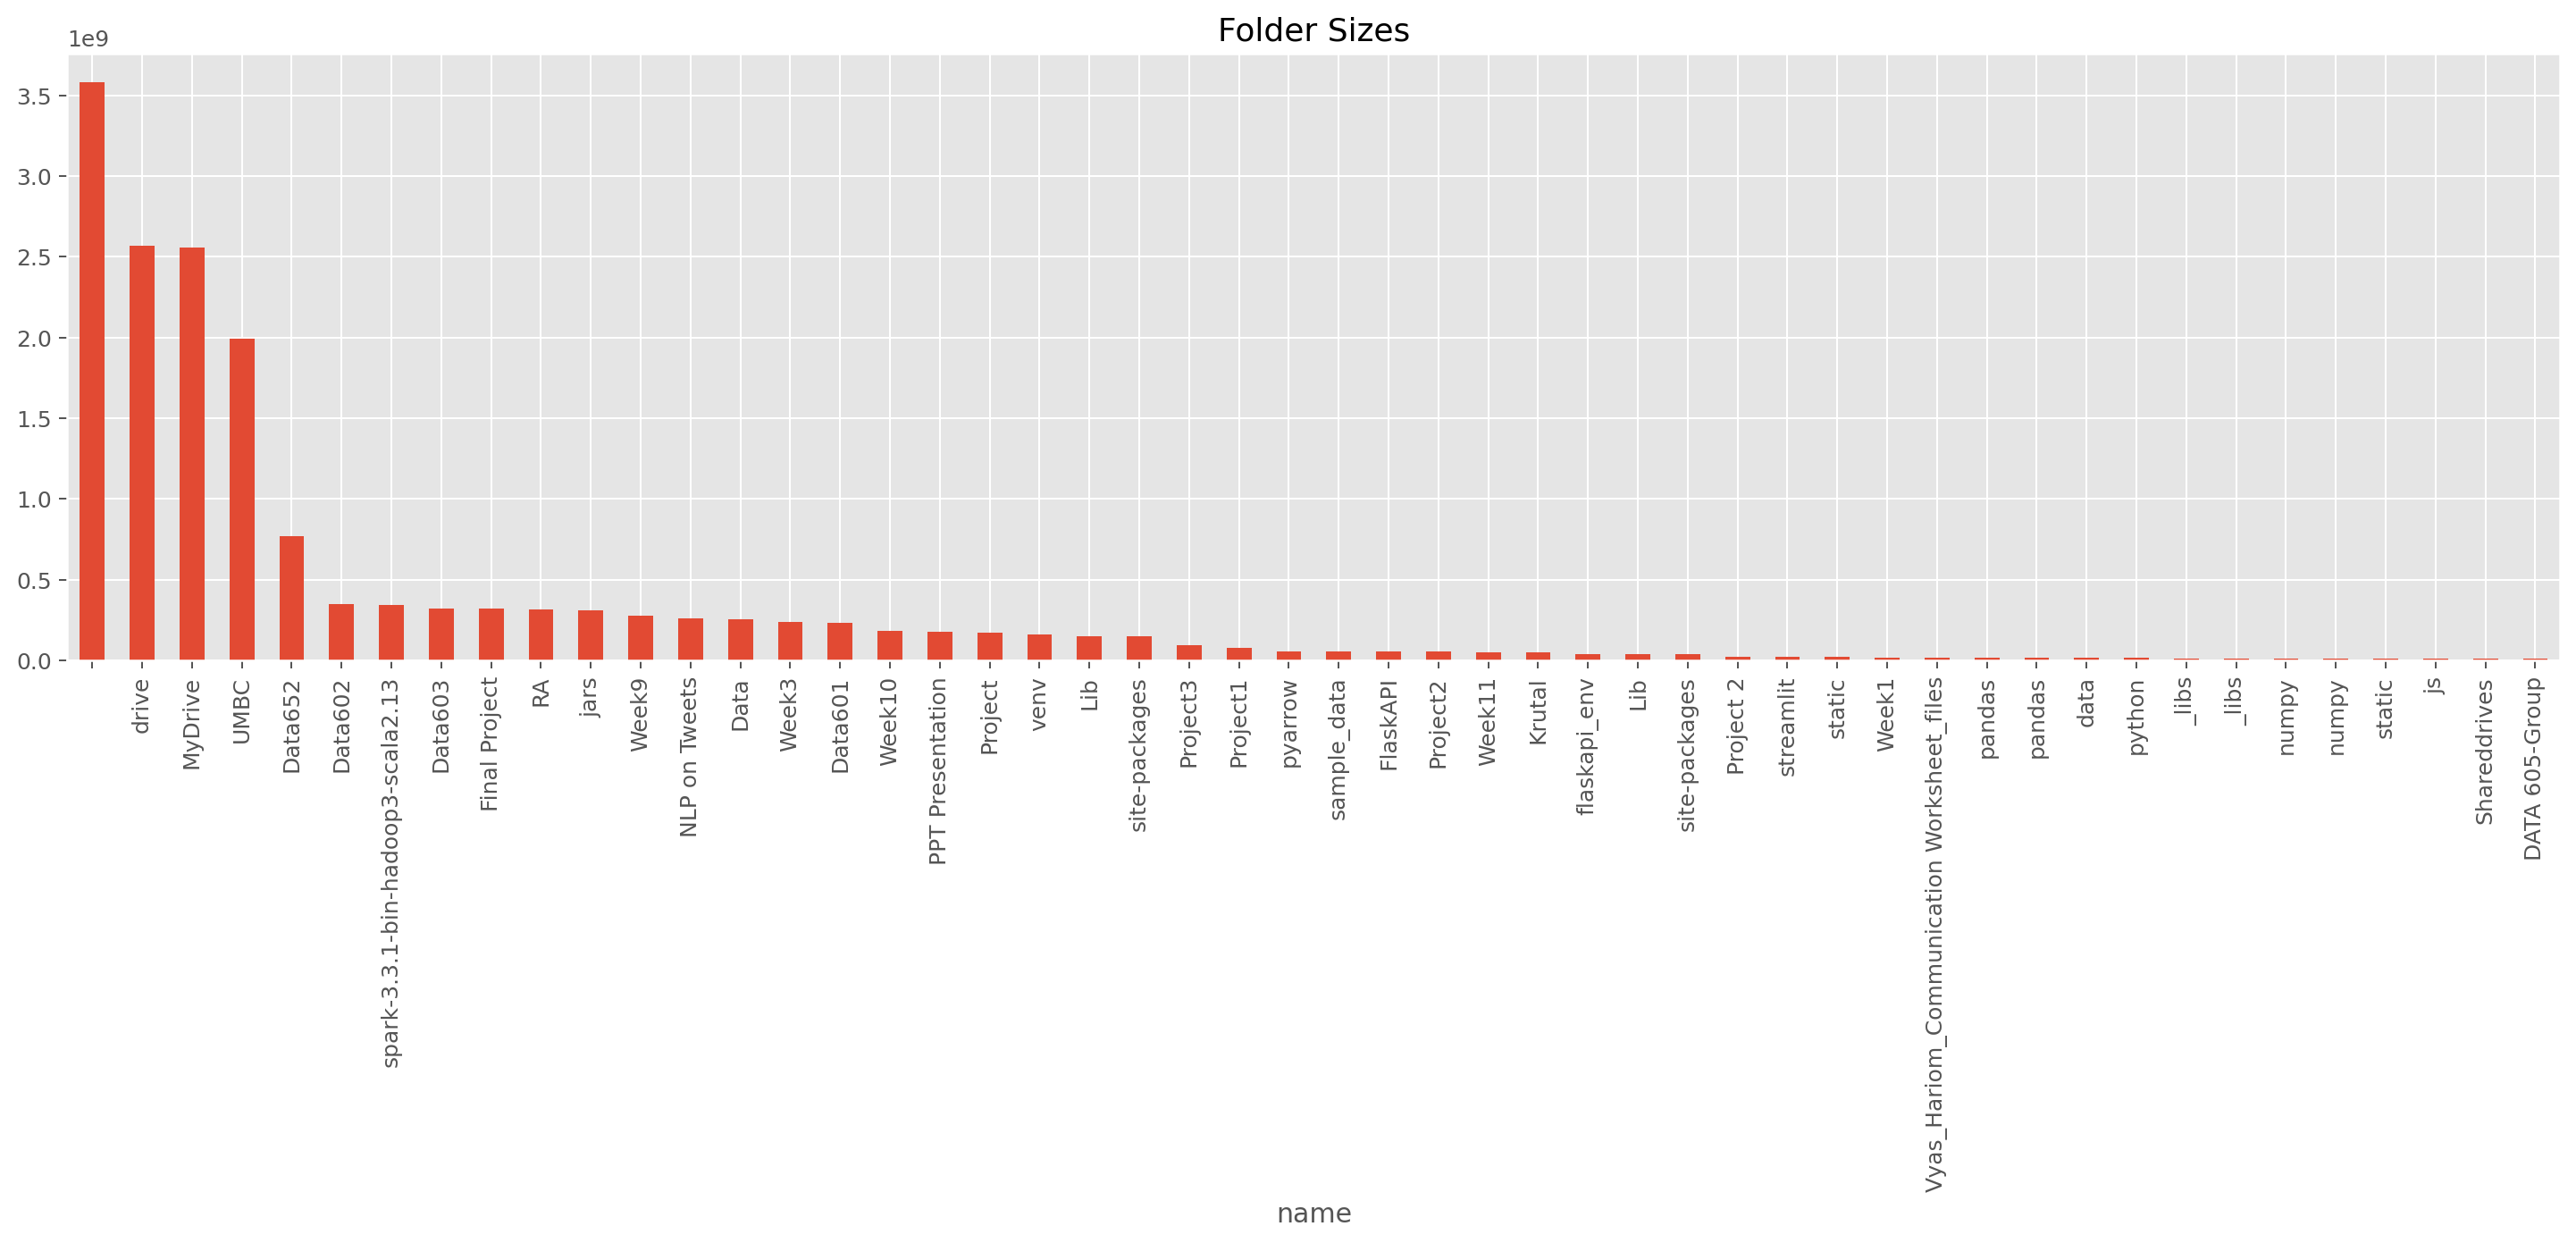

In [ ]:
## Visualizing just folders using Matplotlib

figure(figsize=(20, 5), dpi=180)

with plt.style.context('ggplot'):
    # Filter the data set to only folders
    df_folders = df[df['folder']]
    # Set the name to be the index (so we can use it as a label later)
    df_folders.set_index('name', inplace=True)
    # Sort the folders by size
    df_sizes = df_folders.sort_values(by='size', ascending=False)

    # Show the size of the largest 50 folders as a bar plot
    df_sizes['size'][:50].plot(kind='bar', color='C0', title='Folder Sizes');

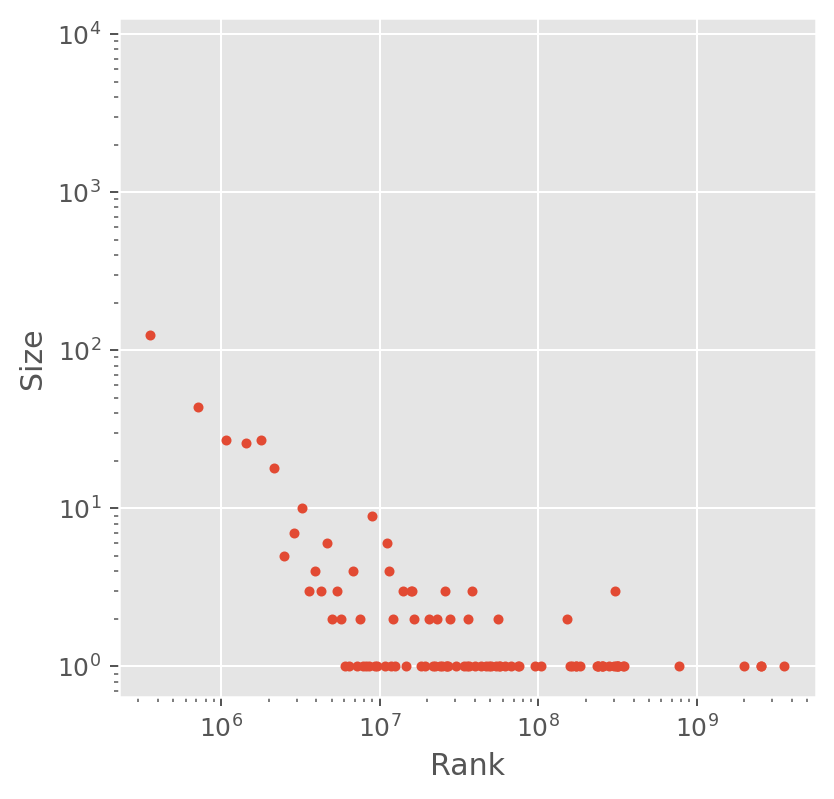

In [ ]:
## Log-scale plotting to explore the size and rank

import numpy as np

figure(figsize=(5, 5), dpi=180)

with plt.style.context('ggplot'):
    y, bins = np.histogram(df['size'], bins=10000)
    plt.loglog(bins[:-1], y, '.');
    plt.ylabel('Size')
    plt.xlabel('Rank')

## Starting our Spark Journey

In [ ]:
## Importing spark dependencies

import pyspark
from pyspark.sql import SparkSession, Row
from pyspark.sql.types import StructType,StructField, StringType, DoubleType, TimestampType, FloatType
from pyspark.sql.functions import from_unixtime, unix_timestamp, col
import pandas as pd

In [ ]:
## Creating Spark Dataframe from our filepaths_list

dfColumns = ["Path", "Size", "MostRecentAccessTime", "MostRecentModificationTime", "MostRecentMetadataChangeTime", "IndexCreationTimestamp"]

filesSchema = StructType([
    StructField('Path', StringType(), True),
    StructField('Size', StringType(), True),
    StructField('MostRecentAccessTime', StringType(), True),
    StructField('MostRecentModificationTime', StringType(), True),
    StructField('MostRecentMetadataChangeTime', StringType(), True),
    StructField('IndexCreationTimestamp', TimestampType(), True),
])

filesDF = spark.createDataFrame(data=filepaths_list, schema = filesSchema)

filesDF.printSchema()
filesDF.show(truncate=False)


root
 |-- Path: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- MostRecentAccessTime: string (nullable = true)
 |-- MostRecentModificationTime: string (nullable = true)
 |-- MostRecentMetadataChangeTime: string (nullable = true)
 |-- IndexCreationTimestamp: timestamp (nullable = true)

+---------------------------------------------+---------+--------------------+--------------------------+----------------------------+--------------------------+
|Path                                         |Size     |MostRecentAccessTime|MostRecentModificationTime|MostRecentMetadataChangeTime|IndexCreationTimestamp    |
+---------------------------------------------+---------+--------------------+--------------------------+----------------------------+--------------------------+
|./drive.csv                                  |1351067  |1.6709743071782963E9|1.6709743072322962E9      |1.6709743072322962E9        |2022-12-13 23:51:10.564041|
|./spark-3.3.1-bin-hadoop3-scala2.13.tgz      |

In [ ]:
## Creating pandas dataframe for future use

pandasDF = pd.DataFrame(filepaths_list, columns=dfColumns)
pandasDF

,Path,Size,MostRecentAccessTime,MostRecentModificationTime,MostRecentMetadataChangeTime,IndexCreationTimestamp
0,./drive.csv,1351067,1.670974e+09,1.670974e+09,1.670974e+09,2022-12-13 23:51:10.564041
1,./spark-3.3.1-bin-hadoop3-scala2.13.tgz,306413381,1.670974e+09,1.665831e+09,1.670974e+09,2022-12-13 23:51:10.564116
2,./spark-3.3.1-bin-hadoop3-scala2.13.tgz.1,306413381,1.670975e+09,1.665831e+09,1.670975e+09,2022-12-13 23:51:10.564165
3,./.config/.last_update_check.json,133,1.670856e+09,1.670856e+09,1.670859e+09,2022-12-13 23:51:10.564267
4,./.config/config_sentinel,0,1.670856e+09,1.670856e+09,1.670859e+09,2022-12-13 23:51:10.564321
...,...,...,...,...,...,...
6602,./sample_data/anscombe.json,1697,9.467136e+08,9.467136e+08,1.670859e+09,2022-12-13 23:51:26.528212
6603,./sample_data/mnist_train_small.csv,36523880,1.670856e+09,1.670856e+09,1.670859e+09,2022-12-13 23:51:26.529505
6604,./sample_data/california_housing_train.csv,1706430,1.670856e+09,1.670856e+09,1.670859e+09,2022-12-13 23:51:26.530845
6605,./sample_data/mnist_test.csv,18289443,1.670856e+09,1.670856e+09,1.670859e+09,2022-12-13 23:51:26.530961


## Data Insights and Pre-processing

In [ ]:
## Changing column types to float for "Size" column

filesDF = filesDF.withColumn("Size", filesDF["Size"].cast(FloatType()))

#.withColumn("MostRecentAccessTime", filesDF["MostRecentAccessTime"].cast(TimestampType())).withColumn("MostRecentModificationTime", filesDF["MostRecentModificationTime"].cast(TimestampType())).withColumn("MostRecentMetadataChangeTime", filesDF["MostRecentMetadataChangeTime"].cast(TimestampType()))
filesDF.printSchema()

root
 |-- Path: string (nullable = true)
 |-- Size: float (nullable = true)
 |-- MostRecentAccessTime: string (nullable = true)
 |-- MostRecentModificationTime: string (nullable = true)
 |-- MostRecentMetadataChangeTime: string (nullable = true)
 |-- IndexCreationTimestamp: timestamp (nullable = true)



In [ ]:
# # Changing colum type to time for other columns

# filesDF = filesDF.select(
#     from_unixtime(col("MostRecentAccessTime")).as("MostRecentAccessTime"),
#     from_unixtime(col("MostRecentModificationTime"), "MM-dd-yyyy HH:mm:ss").alias("MostRecentModificationTime"),
#     from_unixtime(col("MostRecentMetadataChangeTime"), "MM-dd-yyyy HH:mm:ss").alias("MostRecentMetadataChangeTime"),
# )

In [ ]:
filesDF.printSchema()
filesDF.show(truncate=False)

root
 |-- Path: string (nullable = true)
 |-- Size: float (nullable = true)
 |-- MostRecentAccessTime: string (nullable = true)
 |-- MostRecentModificationTime: string (nullable = true)
 |-- MostRecentMetadataChangeTime: string (nullable = true)
 |-- IndexCreationTimestamp: timestamp (nullable = true)

+---------------------------------------------+------------+--------------------+--------------------------+----------------------------+--------------------------+
|Path                                         |Size        |MostRecentAccessTime|MostRecentModificationTime|MostRecentMetadataChangeTime|IndexCreationTimestamp    |
+---------------------------------------------+------------+--------------------+--------------------------+----------------------------+--------------------------+
|./drive.csv                                  |1351067.0   |1.6709743071782963E9|1.6709743072322962E9      |1.6709743072322962E9        |2022-12-13 23:51:10.564041|
|./spark-3.3.1-bin-hadoop3-scala2.13

In [ ]:
filesDF.show(10)

+--------------------+------------+--------------------+--------------------------+----------------------------+----------------------+
|                Path|        Size|MostRecentAccessTime|MostRecentModificationTime|MostRecentMetadataChangeTime|IndexCreationTimestamp|
+--------------------+------------+--------------------+--------------------------+----------------------------+----------------------+
|         ./drive.csv|   1351067.0|1.6709743071782963E9|      1.6709743072322962E9|        1.6709743072322962E9|  2022-12-13 23:51:...|
|./spark-3.3.1-bin...|3.06413376E8|       1.670974107E9|             1.665831233E9|        1.6709741071346824E9|  2022-12-13 23:51:...|
|./spark-3.3.1-bin...|3.06413376E8|       1.670975418E9|             1.665831233E9|        1.6709754182429128E9|  2022-12-13 23:51:...|
|./.config/.last_u...|       133.0|       1.670855692E9|             1.670855692E9|        1.6708588020918188E9|  2022-12-13 23:51:...|
|./.config/config_...|         0.0|       1.6708

In [ ]:
filesDF.count()

6607

In [ ]:
filesDF.summary().show()

+-------+--------------------+-----------------+--------------------+--------------------------+----------------------------+
|summary|                Path|             Size|MostRecentAccessTime|MostRecentModificationTime|MostRecentMetadataChangeTime|
+-------+--------------------+-----------------+--------------------+--------------------------+----------------------------+
|  count|                6607|             6607|                6607|                      6607|                        6607|
|   mean|                null|566516.0228545482| 1.670571988768587E9|      1.6673103592881606E9|        1.6709584160941818E9|
| stddev|                null|9324821.430282421|  2.50056241418219E7|      1.7692895145501655E7|          480238.75588340376|
|    min|./.config/.last_o...|              0.0|                 0.0|             1.385644837E9|               1.650388363E9|
|    25%|                null|           1359.0|       1.670973265E9|             1.665821728E9|               1.67097

In [ ]:
filesDF.describe().show()

+-------+--------------------+-----------------+--------------------+--------------------------+----------------------------+
|summary|                Path|             Size|MostRecentAccessTime|MostRecentModificationTime|MostRecentMetadataChangeTime|
+-------+--------------------+-----------------+--------------------+--------------------------+----------------------------+
|  count|                6607|             6607|                6607|                      6607|                        6607|
|   mean|                null|566516.0228545482| 1.670571988768587E9|      1.6673103592881606E9|        1.6709584160941818E9|
| stddev|                null|9324821.430282421|  2.50056241418219E7|      1.7692895145501655E7|          480238.75588340376|
|    min|./.config/.last_o...|              0.0|                 0.0|             1.385644837E9|               1.650388363E9|
|    max|./spark-3.3.1-bin...|     3.06413376E8|          9.467136E8|                9.467136E8|        1.670975425590

In [ ]:
filesDF.orderBy("Size").show()

+--------------------+----+--------------------+--------------------------+----------------------------+----------------------+
|                Path|Size|MostRecentAccessTime|MostRecentModificationTime|MostRecentMetadataChangeTime|IndexCreationTimestamp|
+--------------------+----+--------------------+--------------------------+----------------------------+----------------------+
|./drive/MyDrive/U...| 0.0|       1.670973041E9|               1.6700603E9|               1.670973041E9|  2022-12-13 23:51:...|
|./drive/MyDrive/U...| 0.0|       1.670973185E9|             1.670060272E9|               1.670973185E9|  2022-12-13 23:51:...|
|./drive/MyDrive/U...| 0.0|       1.670973665E9|             1.670060293E9|               1.670973665E9|  2022-12-13 23:51:...|
|./drive/MyDrive/U...| 0.0|       1.670972991E9|             1.670060278E9|               1.670972991E9|  2022-12-13 23:51:...|
|./drive/MyDrive/U...| 0.0|        1.67097305E9|             1.670060293E9|                1.67097305E9|

In [ ]:
# Finding null values in data

filesDF.filter(filesDF.Path.isNull()).show()
filesDF.filter(filesDF.Size.isNull()).show()
filesDF.filter(filesDF.MostRecentAccessTime.isNull()).show()
filesDF.filter(filesDF.MostRecentModificationTime.isNull()).show()
filesDF.filter(filesDF.MostRecentMetadataChangeTime.isNull()).show()

+----+----+--------------------+--------------------------+----------------------------+----------------------+
|Path|Size|MostRecentAccessTime|MostRecentModificationTime|MostRecentMetadataChangeTime|IndexCreationTimestamp|
+----+----+--------------------+--------------------------+----------------------------+----------------------+
+----+----+--------------------+--------------------------+----------------------------+----------------------+

+----+----+--------------------+--------------------------+----------------------------+----------------------+
|Path|Size|MostRecentAccessTime|MostRecentModificationTime|MostRecentMetadataChangeTime|IndexCreationTimestamp|
+----+----+--------------------+--------------------------+----------------------------+----------------------+
+----+----+--------------------+--------------------------+----------------------------+----------------------+

+----+----+--------------------+--------------------------+----------------------------+--------------

## Creating Functions to Extract data from different forms of files

In [ ]:
!pip install PyPDF2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install docx2txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
## Importing required libraries

import pandas as pd
from pyspark.sql.functions import col, pandas_udf, when, udf
from pyspark.sql.types import LongType
from pyspark.sql import Window

# For PDF Extraction
import PyPDF2

# For Docx
import docx2txt

In [ ]:
# Function to extract data from text file

def extract_from_txt(files_list: pd.Series) -> pd.Series:

  f = open(files_list, "r")
  readtext = f.read()

  return readtext

# creating the pandas udf for extraction function
txt_udf = pandas_udf(extract_from_txt, returnType=StringType())

spark.udf.register("ExtractFromTxt", extract_from_txt)

<function __main__.extract_from_txt(files_list: pandas.core.series.Series) -> pandas.core.series.Series>

In [ ]:
# Function to extract data from Python file

def extract_from_py(files_list: pd.Series) -> pd.Series:

  f = open(files_list, "r")
  readtext = f.read()

  return readtext

# creating the pandas udf for extraction function
py_udf = pandas_udf(extract_from_py, returnType=StringType())

spark.udf.register("ExtractFromPy", extract_from_py)

<function __main__.extract_from_py(files_list: pandas.core.series.Series) -> pandas.core.series.Series>

In [ ]:
# Function to extract data from Docx file

def extract_from_docx(files_list: pd.Series) -> pd.Series:

  my_text = docx2txt.process(zip(files_list))
  return my_text

# creating the pandas udf for extraction function
docx_udf = pandas_udf(extract_from_docx, returnType=StringType())

spark.udf.register("extract_from_docx", extract_from_docx)

<function __main__.extract_from_docx(files_list: pandas.core.series.Series) -> pandas.core.series.Series>

In [ ]:
# Function to extract data from pdf file

def extract_from_pdf(files_list: pd.Series) -> pd.Series:
  extracted_text = ""

  # creating a pdf file object
  pdfFileObj = open(files_list, 'rb')

  # creating a pdf reader object
  pdfReader = PyPDF2.PdfFileReader(pdfFileObj)

  for i in range(pdfReader.numPages):
    # creating a page object
    pageObj = pdfReader.getPage(i)
    extracted_text = extracted_text + pageObj.extractText()

  # closing the pdf file object
  pdfFileObj.close()

  return extracted_text

# creating the pandas udf for extraction function
pdf_udf = pandas_udf(extract_from_pdf, returnType=StringType())

spark.udf.register("extract_from_pdf", extract_from_pdf)

<function __main__.extract_from_pdf(files_list: pandas.core.series.Series) -> pandas.core.series.Series>

In [ ]:
# # Function to extract data from csv file

# def extract_from_csv(files_list: pd.Series) -> pd.Series:

#   df = pd.read_csv(files_list)
#   return df

# # creating the pandas udf for extraction function
# csv_udf = pandas_udf(extract_from_pdf, returnType=StringType())

In [ ]:
# # Function to extract data from excel file

# def extract_from_excel(files_list: pd.Series) -> pd.Series:



In [ ]:
# # Function to extract data from image file

# def extract_from_img(files_list: pd.Series) -> pd.Series:


In [ ]:
filesDF.show(10)

+--------------------+------------+--------------------+--------------------------+----------------------------+----------------------+
|                Path|        Size|MostRecentAccessTime|MostRecentModificationTime|MostRecentMetadataChangeTime|IndexCreationTimestamp|
+--------------------+------------+--------------------+--------------------------+----------------------------+----------------------+
|         ./drive.csv|   1351067.0|1.6709743071782963E9|      1.6709743072322962E9|        1.6709743072322962E9|  2022-12-13 23:51:...|
|./spark-3.3.1-bin...|3.06413376E8|       1.670974107E9|             1.665831233E9|        1.6709741071346824E9|  2022-12-13 23:51:...|
|./spark-3.3.1-bin...|3.06413376E8|       1.670975418E9|             1.665831233E9|        1.6709754182429128E9|  2022-12-13 23:51:...|
|./.config/.last_u...|       133.0|       1.670855692E9|             1.670855692E9|        1.6708588020918188E9|  2022-12-13 23:51:...|
|./.config/config_...|         0.0|       1.6708

## Extracting data using User Defined Functions

In [ ]:
## Creating Doxc file dataframe to extract data

docx_filesDF = filesDF.filter(filesDF.Path.endswith(".docx"))
docx_filesDF.show(10)

+--------------------+--------+--------------------+--------------------------+----------------------------+----------------------+
|                Path|    Size|MostRecentAccessTime|MostRecentModificationTime|MostRecentMetadataChangeTime|IndexCreationTimestamp|
+--------------------+--------+--------------------+--------------------------+----------------------------+----------------------+
|./drive/MyDrive/U...| 15308.0|       1.670972827E9|             1.664233747E9|               1.670972827E9|  2022-12-13 23:51:...|
|./drive/MyDrive/U...|464668.0|       1.670972826E9|             1.670129076E9|               1.670972826E9|  2022-12-13 23:51:...|
|./drive/MyDrive/U...| 12578.0|       1.670972819E9|             1.666045193E9|               1.670972819E9|  2022-12-13 23:51:...|
|./drive/MyDrive/U...| 23047.0|        1.67097283E9|             1.663615491E9|                1.67097283E9|  2022-12-13 23:51:...|
|./drive/MyDrive/U...| 14399.0|       1.670972818E9|             1.645217027

In [ ]:
docx_filesDF.count()

56

In [ ]:
# ## Extracting data from Docx Files

# extract_from_docx = udf(extract_from_docx, StringType())
# docx_filesDF.select("Path", "Size", "MostRecentAccessTime", "MostRecentModificationTime", "MostRecentMetadataChangeTime", "IndexCreationTimestamp", extract_from_docx("Path").alias("Text")).show()

In [ ]:
## Creating Pdf file dataframe to extract data

pdf_filesDF = filesDF.filter(filesDF.Path.endswith(".pdf"))
pdf_filesDF.show(10)

+--------------------+---------+--------------------+--------------------------+----------------------------+----------------------+
|                Path|     Size|MostRecentAccessTime|MostRecentModificationTime|MostRecentMetadataChangeTime|IndexCreationTimestamp|
+--------------------+---------+--------------------+--------------------------+----------------------------+----------------------+
|./drive/MyDrive/V...| 171579.0|                 0.0|             1.654529927E9|               1.654529927E9|  2022-12-13 23:51:...|
|./drive/MyDrive/H...| 130340.0|       1.666381133E9|             1.662589643E9|               1.666381133E9|  2022-12-13 23:51:...|
|./drive/MyDrive/U...| 537176.0|       1.670972828E9|              1.67012911E9|               1.670972828E9|  2022-12-13 23:51:...|
|./drive/MyDrive/U...|  62000.0|        1.67097283E9|             1.647546675E9|                1.67097283E9|  2022-12-13 23:51:...|
|./drive/MyDrive/U...|1415230.0|       1.670972389E9|             1.6

In [ ]:
pdf_filesDF.count()

38

In [ ]:
## Extracting data from PDF Files

extract_from_pdf = udf(extract_from_pdf, StringType())
extracted_pdf_dataDF = pdf_filesDF.select("Path", extract_from_pdf("Path").alias("Text"))

In [ ]:
# extracted_pdf_dataDF.show()

In [ ]:
## Creating Python file dataframe to extract data

py_filesDF = filesDF.filter(filesDF.Path.endswith(".py"))
py_filesDF.show(10)

+--------------------+-------+--------------------+--------------------------+----------------------------+----------------------+
|                Path|   Size|MostRecentAccessTime|MostRecentModificationTime|MostRecentMetadataChangeTime|IndexCreationTimestamp|
+--------------------+-------+--------------------+--------------------------+----------------------------+----------------------+
|./spark-3.3.1-bin...| 1755.0| 1.670975454829832E9|             1.665821723E9|        1.6709754251418977E9|  2022-12-13 23:51:...|
|./spark-3.3.1-bin...| 1976.0| 1.670975454833832E9|             1.665821723E9|        1.6709754251418977E9|  2022-12-13 23:51:...|
|./spark-3.3.1-bin...| 1585.0| 1.670975454834832E9|             1.665821723E9|        1.6709754251418977E9|  2022-12-13 23:51:...|
|./spark-3.3.1-bin...| 1281.0| 1.670975454834832E9|             1.665821723E9|        1.6709754251418977E9|  2022-12-13 23:51:...|
|./spark-3.3.1-bin...| 1513.0| 1.670975454835832E9|             1.665821723E9|     

In [ ]:
py_filesDF.count()

3016

In [ ]:
## Extracting data from Python Files

extract_from_py = udf(extract_from_py, StringType())
extracted_py_dataDF = py_filesDF.select("Path", extract_from_py("Path").alias("Text"))

In [ ]:
extracted_py_dataDF.show()

+--------------------+--------------------+
|                Path|                Text|
+--------------------+--------------------+
|./spark-3.3.1-bin...|#\n# Licensed to ...|
|./spark-3.3.1-bin...|#\n# Licensed to ...|
|./spark-3.3.1-bin...|#\n# Licensed to ...|
|./spark-3.3.1-bin...|#\n# Licensed to ...|
|./spark-3.3.1-bin...|#\n# Licensed to ...|
|./spark-3.3.1-bin...|#\n# Licensed to ...|
|./spark-3.3.1-bin...|#\n# Licensed to ...|
|./spark-3.3.1-bin...|#!/usr/bin/env py...|
|./spark-3.3.1-bin...|#!/usr/bin/env py...|
|./spark-3.3.1-bin...|# -*- coding: utf...|
|./spark-3.3.1-bin...|#\n# Licensed to ...|
|./spark-3.3.1-bin...|"""\nCopyright (c...|
|./spark-3.3.1-bin...|#\n# Licensed to ...|
|./spark-3.3.1-bin...|#!/usr/bin/env py...|
|./spark-3.3.1-bin...|#\n# Licensed to ...|
|./spark-3.3.1-bin...|#\n# Licensed to ...|
|./spark-3.3.1-bin...|#\n# Licensed to ...|
|./spark-3.3.1-bin...|#\n# Licensed to ...|
|./spark-3.3.1-bin...|#\n# Licensed to ...|
|./spark-3.3.1-bin...|#\n# Licen

In [ ]:
## Creating Text file dataframe to extract data

txt_filesDF = filesDF.filter(filesDF.Path.endswith(".txt"))
txt_filesDF.show(10)

+--------------------+------+--------------------+--------------------------+----------------------------+----------------------+
|                Path|  Size|MostRecentAccessTime|MostRecentModificationTime|MostRecentMetadataChangeTime|IndexCreationTimestamp|
+--------------------+------+--------------------+--------------------------+----------------------------+----------------------+
|./spark-3.3.1-bin...|1148.0|1.6709754251498976E9|             1.665821725E9|        1.6709754251498976E9|  2022-12-13 23:51:...|
|./spark-3.3.1-bin...|1314.0|1.6709754251438975E9|             1.665821725E9|        1.6709754251438975E9|  2022-12-13 23:51:...|
|./spark-3.3.1-bin...|1513.0|1.6709754251488976E9|             1.665821725E9|        1.6709754251498976E9|  2022-12-13 23:51:...|
|./spark-3.3.1-bin...|1087.0|1.6709754251418977E9|             1.665821725E9|        1.6709754251418977E9|  2022-12-13 23:51:...|
|./spark-3.3.1-bin...|1487.0|1.6709754251458976E9|             1.665821725E9|        1.670

In [ ]:
txt_filesDF.count()

215

In [ ]:
## Extracting data from Text Files

extract_from_txt = udf(extract_from_txt, StringType())
extracted_txt_dataDF = txt_filesDF.select("Path", extract_from_txt("Path").alias("Text"))
extracted_txt_dataDF.show()

+--------------------+--------------------+
|                Path|                Text|
+--------------------+--------------------+
|./spark-3.3.1-bin...|Copyright (c) 200...|
|./spark-3.3.1-bin...|Copyright (c) 199...|
|./spark-3.3.1-bin...|Copyright (c) 200...|
|./spark-3.3.1-bin...|The MIT License (...|
|./spark-3.3.1-bin...|Copyright (c) 200...|
|./spark-3.3.1-bin...|Copyright 2014 Mo...|
|./spark-3.3.1-bin...|Zstd-jni: JNI bin...|
|./spark-3.3.1-bin...|This project is l...|
|./spark-3.3.1-bin...|Copyright (c) 200...|
|./spark-3.3.1-bin...|The MIT License (...|
|./spark-3.3.1-bin...|Eclipse Distribut...|
|./spark-3.3.1-bin...|Copyright (c) 200...|
|./spark-3.3.1-bin...|Copyright (c) 201...|
|./spark-3.3.1-bin...|The MIT License\n...|
|./spark-3.3.1-bin...|[ ParaNamer used ...|
|./spark-3.3.1-bin...|JTransforms\nCopy...|
|./spark-3.3.1-bin...|Copyright (c) 201...|
|./spark-3.3.1-bin...|Eclipse Distribut...|
|./spark-3.3.1-bin...|COMMON DEVELOPMEN...|
|./spark-3.3.1-bin...|Janino - A

In [ ]:
extracted_txt_dataDF.show()

+--------------------+--------------------+
|                Path|                Text|
+--------------------+--------------------+
|./spark-3.3.1-bin...|Copyright (c) 200...|
|./spark-3.3.1-bin...|Copyright (c) 199...|
|./spark-3.3.1-bin...|Copyright (c) 200...|
|./spark-3.3.1-bin...|The MIT License (...|
|./spark-3.3.1-bin...|Copyright (c) 200...|
|./spark-3.3.1-bin...|Copyright 2014 Mo...|
|./spark-3.3.1-bin...|Zstd-jni: JNI bin...|
|./spark-3.3.1-bin...|This project is l...|
|./spark-3.3.1-bin...|Copyright (c) 200...|
|./spark-3.3.1-bin...|The MIT License (...|
|./spark-3.3.1-bin...|Eclipse Distribut...|
|./spark-3.3.1-bin...|Copyright (c) 200...|
|./spark-3.3.1-bin...|Copyright (c) 201...|
|./spark-3.3.1-bin...|The MIT License\n...|
|./spark-3.3.1-bin...|[ ParaNamer used ...|
|./spark-3.3.1-bin...|JTransforms\nCopy...|
|./spark-3.3.1-bin...|Copyright (c) 201...|
|./spark-3.3.1-bin...|Eclipse Distribut...|
|./spark-3.3.1-bin...|COMMON DEVELOPMEN...|
|./spark-3.3.1-bin...|Janino - A

In [ ]:
# extracted_pdf_dataDF.show()

In [ ]:
## Union of Text and PDF Dataframe

unionDF1 =  extracted_txt_dataDF.union(extracted_pdf_dataDF)
unionDF = unionDF1.union(extracted_py_dataDF)
unionDF.show()
unionDF.count()

+--------------------+--------------------+
|                Path|                Text|
+--------------------+--------------------+
|./spark-3.3.1-bin...|Copyright (c) 200...|
|./spark-3.3.1-bin...|Copyright (c) 199...|
|./spark-3.3.1-bin...|Copyright (c) 200...|
|./spark-3.3.1-bin...|The MIT License (...|
|./spark-3.3.1-bin...|Copyright (c) 200...|
|./spark-3.3.1-bin...|Copyright 2014 Mo...|
|./spark-3.3.1-bin...|Zstd-jni: JNI bin...|
|./spark-3.3.1-bin...|This project is l...|
|./spark-3.3.1-bin...|Copyright (c) 200...|
|./spark-3.3.1-bin...|The MIT License (...|
|./spark-3.3.1-bin...|Eclipse Distribut...|
|./spark-3.3.1-bin...|Copyright (c) 200...|
|./spark-3.3.1-bin...|Copyright (c) 201...|
|./spark-3.3.1-bin...|The MIT License\n...|
|./spark-3.3.1-bin...|[ ParaNamer used ...|
|./spark-3.3.1-bin...|JTransforms\nCopy...|
|./spark-3.3.1-bin...|Copyright (c) 201...|
|./spark-3.3.1-bin...|Eclipse Distribut...|
|./spark-3.3.1-bin...|COMMON DEVELOPMEN...|
|./spark-3.3.1-bin...|Janino - A

3269

In [ ]:
final_filesDF = filesDF.join(unionDF, filesDF.Path == unionDF.Path , "left")

newColumns1 = ["Path", "Size", "MostRecentAccessTime", "MostRecentModificationTime", "MostRecentMetadataChangeTime", "IndexCreationTimestamp", "Temp_Path", "Text"]

final_filesDF = final_filesDF.toDF(*newColumns1)

columns_to_drop = ["Temp_Path"]

new_final_filesDF = final_filesDF.drop(*columns_to_drop)

In [ ]:
!pip install pycryptodome

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 19.1 MB/s 


In [ ]:
final_filesDF.show()

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/content/spark-3.3.1-bin-hadoop3-scala2.13/python/lib/py4j-0.10.9.5-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/content/spark-3.3.1-bin-hadoop3-scala2.13/python/lib/py4j-0.10.9.5-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.8/socket.py", line 669, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: ignored

In [ ]:
# Write CSV file with column header

final_filesDF.write.option("header",True).csv("Indexes.csv")

In [ ]:
# ## Final Spark Dataframe

# new_final_filesDF.show(5)

In [ ]:
# Insights on final Dataframe

new_final_filesDF.printSchema()
new_final_filesDF.count()

## Query Time

In [ ]:
# Finding Single Types of file based on Extension

new_final_filesDF.filter(new_final_filesDF.Path.endswith(".txt")).show()

In [ ]:
# # Finding Single Types of file based on Extension

# new_final_filesDF.filter(('Size > 10000')).show()

In [ ]:
## Function to find the extension of filepaths

new_filesDF = new_final_filesDF.withColumn(
    "Extension", when(col("Path").endswith(".docx"),"docx").
                                 when(col("Path").endswith(".txt"),"txt").
                                 when(col("Path").endswith(".pdf"),"pdf").
                                 when(col("Path").endswith(".jpg"),"jpg").
                                 when(col("Path").endswith(".jpeg"),"jpeg").
                                 when(col("Path").endswith(".png"),"png").
                                 when(col("Path").endswith(".py"),"py").
                                 when(col("Path").endswith(".ipynb"),"ipynb").
                                 when(col("Path").endswith(".log"),"log").
                                 when(col("Path").endswith(".pptx"),"pptx").
                                 when(col("Path").endswith(".mp4"),"mp4").
                                 when(col("Path").endswith(".download"),"download").
                                 when(col("Path").endswith(".js"),"js").
                                 when(col("Path").endswith(".html"),"html").
                                 when(col("Path").endswith(".pyc"),"pyc").
                                 when(col("Path").endswith(".c"),"c").
                                 when(col("Path").endswith(".h"),"h").
                                 when(col("Path").endswith(".pyi"),"pyi").
                                 when(col("Path").endswith(".pyd"),"pyd").
                                 otherwise("unknown"))

In [ ]:
## Groupby Extension

new_filesDF.groupBy('Extension').count().show()

## Updating our Index Dataframe with new data

In [ ]:
from datetime import datetime

def indexUpdater():

  ## Creating a list containg path of the files and its important metadata that we will use in future

  filepaths_list = []
  dfColumns = ["Path", "Size", "MostRecentAccessTime", "MostRecentModificationTime", "MostRecentMetadataChangeTime", "IndexCreationTimestamp"]

  for (dirpath, dirnames, filenames) in os.walk('.'):
      for f in filenames:
          currentDateAndTime = datetime.now()
          filepaths_list.append((
              os.path.join(dirpath, f),
              # os.path.get(os.path.join(dirpath, f)),
              # os.path.getino(os.path.join(dirpath, f)),
              # os.path.getdev(os.path.join(dirpath, f)),
              # os.path.getnlink(os.path.join(dirpath, f)),
              # os.path.getuid(os.path.join(dirpath, f)),
              # os.path.getgid(os.path.join(dirpath, f)),
              os.path.getsize(os.path.join(dirpath, f)),
              os.path.getatime(os.path.join(dirpath, f)),
              os.path.getmtime(os.path.join(dirpath, f)),
              os.path.getctime(os.path.join(dirpath, f)),
              currentDateAndTime
          ))

  filesSchema = StructType([
      StructField('Path', StringType(), True),
      StructField('Size', StringType(), True),
      StructField('MostRecentAccessTime', StringType(), True),
      StructField('MostRecentModificationTime', StringType(), True),
      StructField('MostRecentMetadataChangeTime', StringType(), True),
      StructField('IndexCreationTimestamp', TimestampType(), True),
  ])

  updatedfilesDF = spark.createDataFrame(data=filepaths_list, schema = filesSchema)

  return updatedfilesDF

In [ ]:
# Running Index Updater Program Every 5 Minutes or time set by User

updatedfilesDF = indexUpdater()
updatedfilesDF.show()
updatedfilesDF.count()

In [ ]:
differenceDF = new_filesDF.exceptAll(new_filesDF)
# differenceDF.show()

In [ ]:
## Extracting data from differenceDF

def extractDifferenceData(differenceDF):

  pdf_filesDF = differenceDF.filter(differenceDF.Path.endswith(".pdf"))
  py_filesDF = differenceDF.filter(differenceDF.Path.endswith(".py"))
  txt_filesDF = differenceDF.filter(differenceDF.Path.endswith(".txt"))

  extracted_pdf_dataDF = pdf_filesDF.select("Path", extract_from_pdf("Path").alias("Text"))
  extracted_py_dataDF = py_filesDF.select("Path", extract_from_py("Path").alias("Text"))
  extracted_txt_dataDF = txt_filesDF.select("Path", extract_from_txt("Path").alias("Text"))

  unionDF1 =  extracted_txt_dataDF.union(extracted_pdf_dataDF)
  updatedunionDF = unionDF1.union(extracted_py_dataDF)

  return updatedunionDF

In [ ]:
updatedunionDF = extractDifferenceData(differenceDF)

final_filesDF = filesDF.join(updatedunionDF, filesDF.Path == updatedunionDF.Path , "left")

newColumns1 = ["Path", "Size", "MostRecentAccessTime", "MostRecentModificationTime", "MostRecentMetadataChangeTime", "IndexCreationTimestamp", "Temp_Path", "Text"]

final_filesDF = final_filesDF.toDF(*newColumns1)

columns_to_drop = ["Temp_Path"]

new_final_filesDF = final_filesDF.drop(*columns_to_drop)

In [ ]:
# new_final_filesDF.show()

## Writing Indexes to a CSV File to use it for other things.

In [ ]:
# Write CSV file with column header

new_final_filesDF.write.option("header",True).csv("Indexes.csv")